<a href="https://colab.research.google.com/github/Jeongho-K/Car-model-classification/blob/main/code/1_Color_classification_with_efficient_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Color classification

data: https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=554

## 코랩 내 zip 파일 압축 풀기

In [ ]:
# 구글 마운트
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Car-model-classification/data/1.Training/라벨링데이터
!unzip -qq 'TL1.zip'
!unzip -qq 'TL2.zip'
!unzip -qq 'TL3.zip'
!unzip -qq 'TL4.zip'

In [ ]:
%cd /content/drive/MyDrive/Car-model-classification/data/1.Training/원천데이터
!unzip -qq 'TS1.zip'
!unzip -qq 'TS2.zip'
!unzip -qq 'TS3.zip'
!unzip -qq 'TS4.zip'

/content/drive/MyDrive/Car-model-classification/data/1.Training/원천데이터


In [ ]:
%cd /content/drive/MyDrive/Car-model-classification/data/2.Validation/라벨링데이터
!unzip -qq 'VL1.zip'
!unzip -qq 'VL2.zip'
!unzip -qq 'VL3.zip'
!unzip -qq 'VL4.zip'

/content/drive/MyDrive/Car-model-classification/data/2.Validation/라벨링데이터


In [ ]:
%cd /content/drive/MyDrive/Car-model-classification/data/2.Validation/원천데이터
!unzip -qq 'VS1.zip'
!unzip -qq 'VS2.zip'
!unzip -qq 'VS3.zip' 
!unzip -qq 'VS4.zip'

/content/drive/MyDrive/Car-model-classification/data/2.Validation/원천데이터


## 데이터 전처리

In [ ]:
%cd /content/drive/MyDrive/Car-model-classification

/content/drive/MyDrive/Car-model-classification


### 이미지 crop

In [ ]:
import os
import json
import numpy as np
import cv2

In [ ]:
# 텍스트 읽기
def read_text(file_path, encoding="utf-8"):
    text = None
    with open(file_path, 'r', encoding=encoding) as f:
        text = f.read()
    return text

In [ ]:
def load_json(json_path, encoding="utf-8"):
    return json.loads(read_text(json_path, encoding))

In [ ]:
def check_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [ ]:
# box 정보에 대해 margin 값만큼 확장함
def expand_box(box, margin, img_width = None, img_height = None):
    x = box["left"]
    y = box["top"]
    w = box["width"]
    h = box["height"]

    x = x - margin
    x = max(x, 0)
    y = y - margin
    y = max(y, 0)

    w = w + 2*margin
    if img_width and x + w > img_width:
        w = img_width - x
    
    h = h + 2*margin
    if img_height and y + h > img_height:
        h = img_height - y

    new_box = {
        "left": x, 
        "top": y,
        "width": w,
        "height": h
    }

    return new_box

In [ ]:
# 이미지 crop
def crop_image(image_np, box, margin = 0):
    if margin > 0:
        box = expand_box(box, margin)
       
    x1 = box["left"]
    y1 = box["top"]
    x2 = box["left"] + box["width"]
    y2 = box["top"] + box["height"]
    return image_np[y1:y2, x1:x2]

In [ ]:
# 한글 경로 지원
def imread( file_path ) :
    stream = open( file_path.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    np_array = np.asarray(bytes, dtype=np.uint8)
    return cv2.imdecode(np_array , cv2.IMREAD_UNCHANGED)

In [ ]:
# 한글 경로 지원
def imwrite(file_path, img, params=None):
    try: 
        ext = os.path.splitext(file_path)[1]
        result, n = cv2.imencode(ext, img, params)
        if result: 
            with open(file_path, mode='w+b') as f:
                n.tofile(f)
                return True
        else: 
            return False 
    except Exception as e: 
        print(e)
        return False

In [ ]:
# 전체 이미지 bbox가 있는 경우 crop해서 저장 color정보에 따라 저장
BASE_LABEL_FOLDER = r"./data/1.Training/라벨링데이터"
BASE_OUTPUT_FOLDER = r'./data/cropmg'

for brand in os.listdir(BASE_LABEL_FOLDER):
    brand_path = os.path.join(BASE_LABEL_FOLDER, brand)

    for model_name in os.listdir(brand_path):
        model_path = os.path.join(brand_path, model_name)

        for detail_forder in os.listdir(model_path):
            folder_path = os.path.join(model_path, detail_forder)

            for file in os.listdir(folder_path):
                json_path = os.path.join(folder_path, file)
                tmp_json = load_json(json_path)
                object_list = tmp_json["learningDataInfo"]["objects"]

                for i in range(len(object_list)):
                    if tmp_json["learningDataInfo"]["objects"][i]["classId"] == 'P00.차량전체':
                        img_file_path = str(tmp_json["sourceDataInfo"]["sourceDataID"]) + '.jpg'
                        tmp_list = folder_path.split('/')
                        tmp_list[3] = '원천데이터'
                        img_path = os.path.join('/'.join(tmp_list), img_file_path)

                        # 차량 전체 bbox
                        box = {
                                "left": int(tmp_json["learningDataInfo"]["objects"][i]["left"]),
                                "top": int(tmp_json["learningDataInfo"]["objects"][i]["top"]),
                                "width": int(tmp_json["learningDataInfo"]["objects"][i]["width"]),
                                "height": int(tmp_json["learningDataInfo"]["objects"][i]["height"])
                            }

                        # 이미지 크롭
                        img = imread(img_path)
                        cropped_img = crop_image(img, box)

                        # 색상 폴더 확인 후 생성
                        output_folder = os.path.join(BASE_OUTPUT_FOLDER, tmp_json['rawDataInfo']['colorId'])
                        check_folder(output_folder)
                        output_path = os.path.join(output_folder, str(img_file_path))

                        imwrite(output_path, cropped_img)
    print(brand)

In [32]:
base_cropimg = '/content/drive/MyDrive/Car-model-classification/data/cropimg/'

black_list = os.listdir(os.path.join(base_cropimg, '검정'))
red_list = os.listdir(os.path.join(base_cropimg, '빨강'))
blue_list = os.listdir(os.path.join(base_cropimg, '파랑'))
grey_list = os.listdir(os.path.join(base_cropimg, '회색'))
white_list = os.listdir(os.path.join(base_cropimg, '흰색'))

print(len(black_list))
print(len(red_list))
print(len(blue_list))
print(len(grey_list))
print(len(white_list))

1000
1000
1000
1000
1000


In [28]:
def remove_files(file_list):
    for file in file_list:
        os.remove(file)

In [ ]:
# class 비율 맞추기
import random
black_path = random.sample(black_list, 6585)
red_path = random.sample(red_list, 277)
blue_path = random.sample(blue_list, 3678)
grey_path = random.sample(grey_list, 6424)
white_path = random.sample(white_list, 8144)

%cd '/content/drive/MyDrive/Car-model-classification/data/cropimg/검정'
remove_files(black_path)
%cd '/content/drive/MyDrive/Car-model-classification/data/cropimg/빨강'
remove_files(red_path)
%cd '/content/drive/MyDrive/Car-model-classification/data/cropimg/파랑'
remove_files(blue_path)
%cd '/content/drive/MyDrive/Car-model-classification/data/cropimg/회색'
remove_files(grey_path)
%cd '/content/drive/MyDrive/Car-model-classification/data/cropimg/흰색'
remove_files(white_path)
%cd '/content'

## Imports

In [ ]:
pip install efficientnet

In [36]:
import efficientnet.keras as efn
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop

## Hyper parameters

In [48]:
batch_size = 48

width = 150
height = 150
epochs = 20
dropout_rate = 0.2
input_shape = (height, width, 3)

## prepare dataset

In [ ]:
pip install split-folders

In [39]:
import splitfolders

splitfolders.ratio("/content/drive/MyDrive/Car-model-classification/data/cropimg", output="/content/drive/MyDrive/Car-model-classification/data/result", seed=1, ratio=(.8, .2))

Copying files: 5000 files [02:16, 36.71 files/s]


In [40]:
base_dir = '/content/drive/MyDrive/Car-model-classification/data/result'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

ImageDataGenerator  
* rotation_range : 이미지회전값  
* zoom_range : 이미지일부확대  
* shear_range : 이미지기울기  
* width_shift_range : 좌우이동  
* height_shift_range : 상하이동  
* horizontal_flip : 이미지가로뒤집기  
* vertical_filp : 이미지세로뒤집기

In [41]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 45,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              target_size = (width,height))

val_generator = val_datagen.flow_from_directory(val_dir,
                                          batch_size = batch_size,
                                          class_mode = 'categorical',
                                          target_size = (width,height))

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


## load the conv base model

In [42]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3),
                                include_top = False, weights = 'imagenet')

16804768/16804768 [==============================] - 0s 0us/step


In [43]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalMaxPooling2D(name="gap")) # 최대값을 뽑아내서 overfitting 회피
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out")) # 비율로 연결을 끊어 overfitting 회피
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(5, activation='softmax', name="fc_out")) # 결과

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 5)                 6405      
                                                                 
Total params: 4,055,969
Trainable params: 4,013,953
Non-trainable params: 42,016
_________________________________________________________________


In [45]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

base_model.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      epochs=epochs,
      validation_data=val_generator,
      verbose=1,
      use_multiprocessing=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
84/84 [==============================] - 199s 2s/step - loss: 3.6304 - acc: 0.2007 - val_loss: 2.8612 - val_acc: 0.1830
Epoch 2/20
84/84 [==============================] - 180s 2s/step - loss: 3.5026 - acc: 0.2058 - val_loss: 2.7283 - val_acc: 0.2060
Epoch 3/20
84/84 [==============================] - 190s 2s/step - loss: 3.2886 - acc: 0.2202 - val_loss: 2.5919 - val_acc: 0.2220
Epoch 4/20
84/84 [==============================] - 188s 2s/step - loss: 3.1956 - acc: 0.2348 - val_loss: 2.4469 - val_acc: 0.2480
Epoch 5/20
84/84 [==============================] - 188s 2s/step - loss: 3.0777 - acc: 0.2420 - val_loss: 2.3720 - val_acc: 0.2580
Epoch 6/20
84/84 [==============================] - 205s 2s/step - loss: 2.9555 - acc: 0.2585 - val_loss: 2.2553 - val_acc: 0.2850
Epoch 7/20
84/84 [==============================] - 186s 2s/step - loss: 2.8646 - acc: 0.2680 - val_loss: 2.1691 - val_acc: 0.2980
Epoch 8/20
84/84 [==============================] - 188s 2s/step - loss: 2.7448 - a

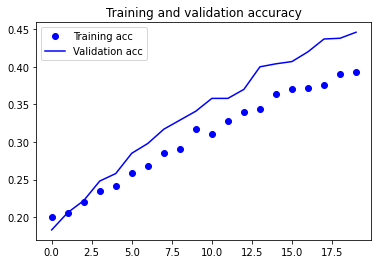

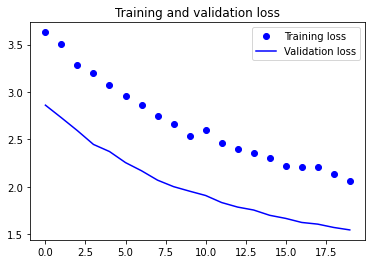

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine tuning last several layers.

In [51]:
# multiply_16
# set 'multiply_16' and following layers trainable
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [52]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      epochs=epochs,
      validation_data=val_generator,
      verbose=1,
      use_multiprocessing=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
84/84 [==============================] - 201s 2s/step - loss: 2.0103 - acc: 0.4017 - val_loss: 1.5159 - val_acc: 0.4540
Epoch 2/20
84/84 [==============================] - 185s 2s/step - loss: 1.9952 - acc: 0.4092 - val_loss: 1.4899 - val_acc: 0.4620
Epoch 3/20
84/84 [==============================] - 186s 2s/step - loss: 1.9705 - acc: 0.4218 - val_loss: 1.4764 - val_acc: 0.4730
Epoch 4/20
84/84 [==============================] - 201s 2s/step - loss: 2.0022 - acc: 0.4137 - val_loss: 1.4462 - val_acc: 0.4730
Epoch 5/20
84/84 [==============================] - 194s 2s/step - loss: 1.8949 - acc: 0.4255 - val_loss: 1.4186 - val_acc: 0.4860
Epoch 6/20
84/84 [==============================] - 188s 2s/step - loss: 1.8806 - acc: 0.4453 - val_loss: 1.3921 - val_acc: 0.4890
Epoch 7/20
84/84 [==============================] - 190s 2s/step - loss: 1.8811 - acc: 0.4412 - val_loss: 1.3788 - val_acc: 0.5000
Epoch 8/20
84/84 [==============================] - 189s 2s/step - loss: 1.8219 - a

In [53]:
os.makedirs("./models", exist_ok=True)
model.save('./models/color.h5')

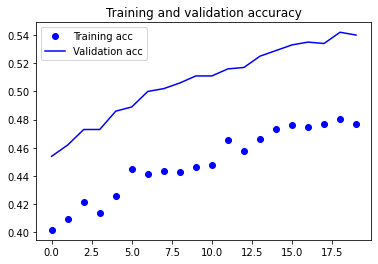

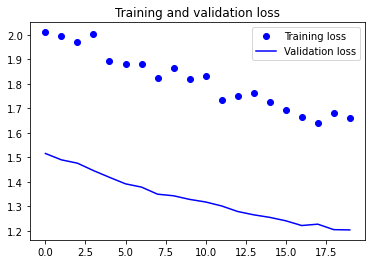

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Download the model

In [55]:
from google.colab import files

files.download('./models/color.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
model.input_shape

(None, 224, 224, 3)

## Load the model

In [ ]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("./models/color.h5")